# Functions to denormlize scRNA-seq data

> The main functions of denormlizing the normlized scRNA-seq data

In [1]:
#| default_exp denorm

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()

In [19]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from tqdm import tqdm
from pathlib import Path
from fastcore.script import *
import logging
logging.getLogger().setLevel(logging.INFO)

## Functions

In [5]:
#| export
@call_parse
def scdenorm(fin:str, # The input file or AnnData
             fout:str = None, # The path of output file if provided
             gxc:bool = False, # Change to True if the data is stored with gene by cell
             base:float = None, # Give the base if it is known
             cont:float = 1.0, # The constant plused after scaling
             cutoff:float = 0.05, 
             verbose:int = 0):
    """
    denormalize takes a cell * gene expression matrix that has been normalized according to single-cell RNA 
    sequencing preprocessing procedure and return a recovered count matrix by reversing the logarithmization step
    and then the total-count normalization step utilizing the unscale function. If the imput matrix is not 
    normalized by first total-count scaling then logarithmization, then the function produces an error
    indicating so. We also handle matrices that have not been logarithmized.
    denormalize: csr_matrix -> csr_matrix
    """
    levels = [logging.WARNING, logging.INFO, logging.DEBUG]
    logging.getLogger().setLevel(levels[verbose] if verbose<3 else logging.INFO)
    try:
        fin=Path(fin)
        logging.info(f'Reading input file: {fin}')
        ad=sc.read(fin)
    except:
        ad=fin
    logging.info(f'The dimensions of this data are {ad.shape}.')
    if gxc: #if data is gene by cell
        logging.info(f'The data is gene by cell. It is transposed to cell by gene {ad.T.shape}')
        ad=ad.T
    smtx=ad.X  #must be cell by gene
    smtx.eliminate_zeros() #remove potential 0s.
    #select base and denormlize
    if base is None:
        logging.info('select base')
        base = select_base(smtx.getrow(0).data,cont,cutoff)
    logging.info('denormlizing ...')
    if check_unscale(smtx.getrow(0).data,base,cont,cutoff):
        counts,success_cells=unscale_mat(smtx,base,cont,cutoff)
        ad=ad[success_cells,:] #filter failed cells
    else:
        logging.error('Denormlization has failed. Output the orignal data')
        counts=smtx
    if fout is None:
        ad.X=counts
        return ad
    #write output
    logging.info(f'Writing output file: {fout}')
    if fout.endswith('.mtx'):
        mmwrite(fout, counts, field = 'integer')
    else:
        ad.X=counts
        ad.write(fout)    

In [6]:
#| export
def unscale_mat(smtx,base=np.e,cont=1,cutoff=0.05):
    """
    unscale takes a cell * gene expression matrix that has been quality-controlled and scaled according to 
    single-cell RNA sequencing preprocessing procedure and return a recovered count matrix 
    by finding the scaling factor for each cell,
    or produce an error indicating the matrix has not been processed by our assumption.
    unscale: csr_matrix -> csr_matrix
    """
    scaled_counts=smtx.copy()
    if base!=1:
        scaled_counts.data = base ** scaled_counts.data - cont
    #get scale factors
    scaling_factors,success_cells=[],[]
    for i in tqdm(range(scaled_counts.shape[0])):
        try:
            scaling_factors.append(get_scaling_factor(scaled_counts.getrow(i).data,cutoff))
            success_cells.append(i)
        except:
            logging.warning(f"Warning:The cell {i} fails to denormlize, and be deleted")
    
    #remove failed cells
    scaled_counts=scaled_counts[success_cells,:]
    scaling_factors = diags(scaling_factors)
    counts = scaling_factors*scaled_counts
    return counts.rint(),success_cells

def select_base(x,cont=1,cutoff=0.05,plot=False):
    for b in [np.e,2,10,1]:
        if check_unscale(x,b,cont,cutoff,plot):
            break
    return b

def check_unscale(x,base=np.e,cont=1,cutoff=0.05,plot=True):
    if base!=1:
        x=base**x-cont
    try:
        get_scaling_factor(x,cutoff)
        return True
    except:
        logging.error(f'The base {base} is not match with the data.')
        if plot:
            check_plot(pd.Series(x),base)
    return False

def get_scaling_factor(x,cutoff=0.05):
    """
    get_scaling_factor takes a cell vector and its index in the gene expression matrix 
    that has been scaled according to single-cell RNA sequencing preprocessing procedure 
    and return the scaling factor for the cell,
    or produce an error indicating the cell has not been processed by our assumption.
    get_scaling_factor: ndarray Nat (Num) -> Num
    """
    x=pd.Series(x)
    xm=x.min()
    x=x/xm
    if np.abs(x-x.round()).mean()>cutoff:
        raise 
    return 1/xm

def get_scaling_factor_1(x):
    ''' x is a normlized cell '''
    x=x.astype('float16')
    y=np.array(x.value_counts().sort_index().head(2).index)
    if np.abs(y[0]-y[1]/2)>10**-5:
        raise
    return 1/y[0]

In [7]:
#| export
def check_plot(c,idx,n=10):
    """
    Check_plot takes a cell vector and its index in the gene expression matrix and produce a plot of the first
    N most frequent values against their ranks. Such a plot is used for error-checking in the unscaling process.
    """
    y = np.array(c.value_counts().sort_index().head(n).index)
    x = np.arange(1, n+1)
    plt.scatter(x, y, label=f'Base {idx}')
    plt.legend()
    plt.xlabel('Rank in cell histogram')
    plt.ylabel('Scaled count')
    plt.xticks(x)

## create test data

In [10]:
prefix = '/home/huang_ziliang/project/brain/data/public/brain_source_Allaway_2021/GSE165233-GPL19057_series_matrix.txt.gz'

In [12]:
ad=sc.read('../../projA/data/pbmc3k_raw.h5ad')

In [13]:
ad

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [14]:
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)
smtx = ad.X.tocsr().asfptype()

In [9]:
ad = sc.read_mtx(prefix+'brain_source_Kevin_2020/raw_data/GSE130708_RAW/GSM3748088_951c/GSM3748088_951c_matrix.mtx.gz')
ad=ad.T
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)
smtx = ad.X.tocsr().asfptype()

FileNotFoundError: [Errno 2] No such file or directory: '/home/huang_ziliang/project/brain/data/public/brain_source_Kevin_2020/raw_data/GSE130708_RAW/GSM3748088_951c/GSM3748088_951c_matrix.mtx.gz'

In [15]:
smtx.data

array([1.6352079, 1.6352079, 2.2258174, ..., 1.7980369, 1.7980369,
       2.779648 ], dtype=float32)

### Testing check_unscale

In [16]:
x=smtx.getrow(0).data

In [17]:
check_unscale(x)

True

ERROR:root:The base 2 is not match with the data.


False

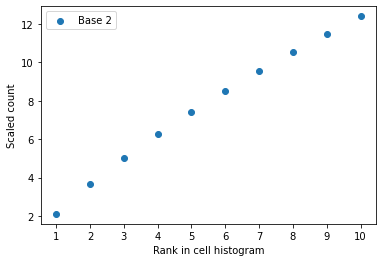

In [20]:
check_unscale(x,base=2)

### Testing scdenorm

In [25]:
mmwrite('scaled.mtx', smtx[1:10,])

In [26]:
ad1=sc.read('scaled.mtx')

In [27]:
ad1

AnnData object with n_obs × n_vars = 9 × 27998

In [173]:
mmwrite('scaled_tran.mtx', smtx.transpose())

In [42]:
unscale_mat(ad1.X)

100%|██████████| 9/9 [00:00<00:00, 1272.63it/s]


(<9x27998 sparse matrix of type '<class 'numpy.float64'>'
 	with 25814 stored elements in Compressed Sparse Row format>,
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [82]:
scdenorm('scaled.mtx',fout='scd_scaled.h5ad',base=np.e)

100%|██████████| 9/9 [00:00<00:00, 1304.79it/s]


INFO:root:Reading input file: scaled.mtx
INFO:root:The dimensions of this data are (9, 27998).
INFO:root:denormlizing ...
ERROR:root:The base 2 is not match with the data.


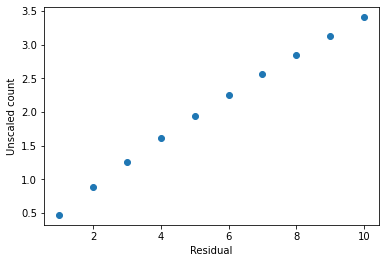

ERROR:root:Denormlization has failed. Output the orignal data
INFO:root:Writing output file: scd_scaled.h5ad


In [52]:
scdenorm('scaled.mtx',fout='scd_scaled.h5ad',base=2)

In [53]:
scdenorm('scaled.mtx',fout='scd_scaled.h5ad')

INFO:root:Reading input file: scaled.mtx
INFO:root:The dimensions of this data are (9, 27998).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 1312.09it/s]
INFO:root:Writing output file: scd_scaled.h5ad


In [72]:
scdenorm('scaled.mtx')

INFO:root:Reading input file: scaled.mtx
INFO:root:The dimensions of this data are (9, 27998).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 1324.52it/s]


View of AnnData object with n_obs × n_vars = 9 × 27998

In [73]:
scdenorm(ad1)

INFO:root:The dimensions of this data are (9, 27998).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 1318.41it/s]


View of AnnData object with n_obs × n_vars = 9 × 27998